In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

import os
import numpy as np
import matplotlib.pyplot as plt


os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [5]:
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


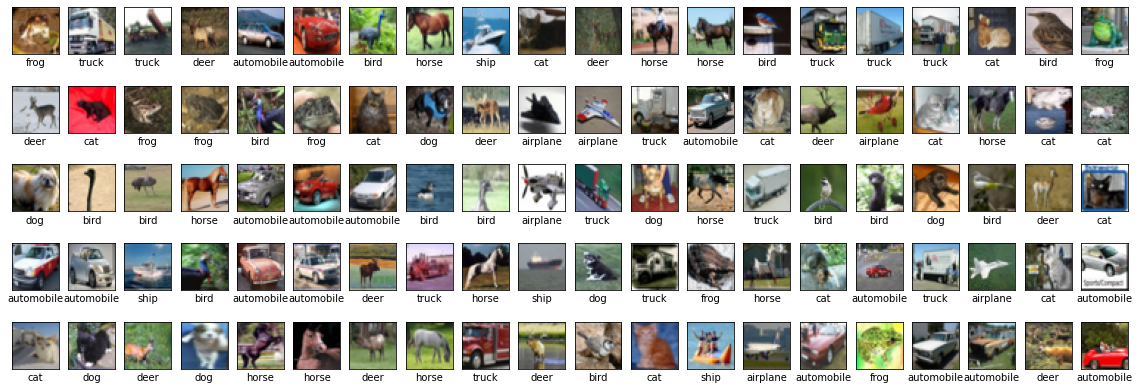

In [7]:
# visualizing the dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
i=0
plt.figure(figsize=(20,7))
for i in range (100):
  plt.subplot(5,20,i+1)
  plt.imshow(x_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(classes[ y_train[i][0] ])
plt.show()

In [9]:
num_training = 5000
mask = list(range(num_training))
x_train = x_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
x_test = x_test[mask]
y_test = y_test[mask]


In [10]:
# reshaping the image data into rows
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape, x_test.shape)

(5000, 3072) (500, 3072)


In [44]:
class KNearestNeighbor(object):

  def __init__(self):
    pass

  def train(self, X, y):
    self.X_train = X
    self.y_train = y
  

In [51]:
  def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)

In [54]:
 def compute_distances_two_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]

In [ ]:
dists = np.zeros((num_test, num_train))
   for i in range(num_test):
        for j in range(num_train):
        dists[i][j] = np.sqrt(np.sum(np.square(X[i] - x_train[j])))
    return dists

In [88]:
 def predict_labels(self, dists, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      closest_y = []
      closest_y = np.take(self.y_train, np.argsort(dists[i]))[:k]
      (values, counts) = np.unique(closest_y, return_counts=True)
      y_pred[i] = values[np.argmax(counts)]

    return y_pred

In [89]:
classifier = KNearestNeighbor()
classifier.train(x_train, y_train)

In [ ]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=1)

# correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)                                       
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

In [92]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

AttributeError: 'KNearestNeighbor' object has no attribute 'predict_labels'

In [94]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

x_train_folds = []
y_train_folds = []

x_train_folds = np.array(np.split(x_train, 5))
y_train_folds = np.split(y_train,5)

k_to_accuracies = {}


fold_classifier = KNearestNeighbor()
for k in k_choices:
  k_to_accuracies[k] = []

  for validation_fold in range(0,num_folds):
    folds = np.arange(0, num_folds)
    folds = np.delete(folds, validation_fold)
    
    # current training set and labels
    x_train_fold = np.take(x_train_folds, folds, axis=0).reshape((4000, x_train_folds.shape[2]))
    y_train_fold = np.take(y_train_folds, folds, axis=0).reshape((4000))
    fold_classifier.train(x_train_fold, y_train_fold)
    
    # computing distance and predict
    dists_folds = fold_classifier.compute_distances_no_loops(x_train_folds[validation_fold,:,:])
    y_test_pred = fold_classifier.predict_labels(dists_folds, k=k)

    # computing accuracy
    num_correct = np.sum(y_test_pred == y_train_folds[validation_fold])
    accuracy = float(num_correct) / 1000

    k_to_accuracies[k].append(accuracy)



for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

AttributeError: 'KNearestNeighbor' object has no attribute 'compute_distances_no_loops'

KeyError: 3

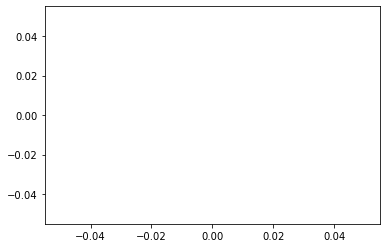

In [95]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()